In [5]:
from Parser import parse_frames
from scipy.signal import medfilt, argrelextrema, argrelmin
import numpy as np
import math
import glob
import os
import matplotlib.pyplot as plt

# Need a folder with npy compressed files of videos


Starting...
Keypoints from folder: output_points_bicep_correct2
Detected arm: left
Largest angles between upper arm and trunk: [4.97587166 3.05899109 0.9839318  4.63095509 6.74689794 4.20127955
 1.29454054 0.91715868 4.30186262]
Largest angles between trunk and knee: [120.01348919 124.82923178 125.04615919 120.01179094 120.82959434
 120.10639393 120.21050221 120.75603123 121.00389389]
Number of maxima points between Upper Arm and Forearm: 1
[170.00216374]
Number of reps performed: 2
[54.49657773 55.47503239]


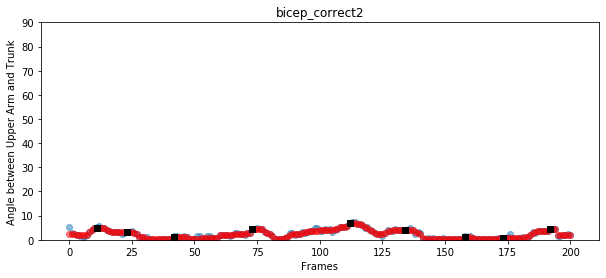

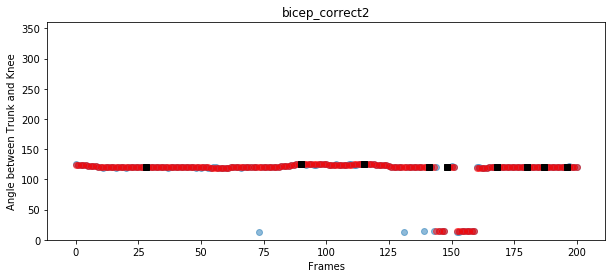

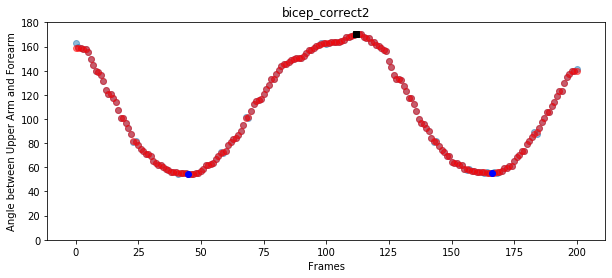

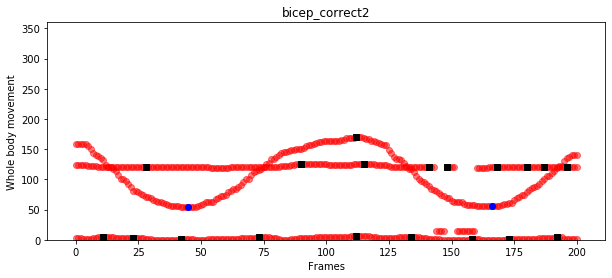

Angles between upper arm and trunk
Max angle: 7.4972220972903445
Min angle: 0.08778541923566362


Angles between upper arm and forearm
Max angle: 170.64132874890032
Min angle: 54.24463323110033


Starting...
Keypoints from folder: output_points_bicep_correct3
Detected arm: right
Largest angles between upper arm and trunk: [11.72920747 10.36260645 10.04199859]
Largest angles between trunk and knee: [179.27585673 177.47939652 179.54615662 179.05735632 179.07830363
 179.68122304 177.74395324]
Number of maxima points between Upper Arm and Forearm: 0
[]
Number of reps performed: 1
[50.30731823]


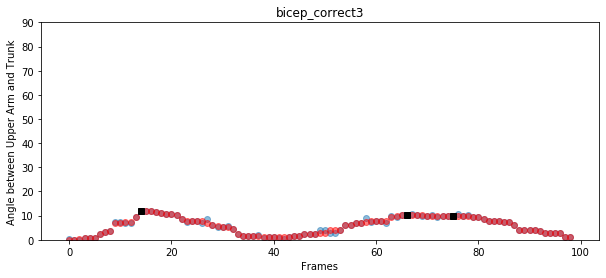

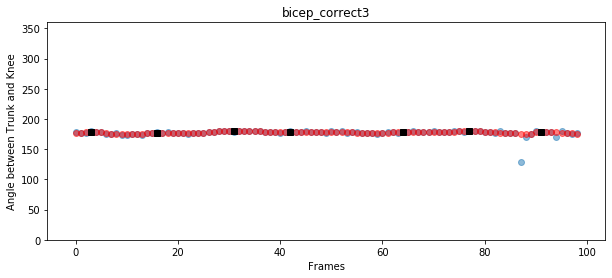

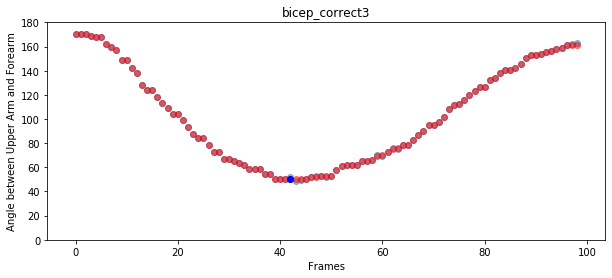

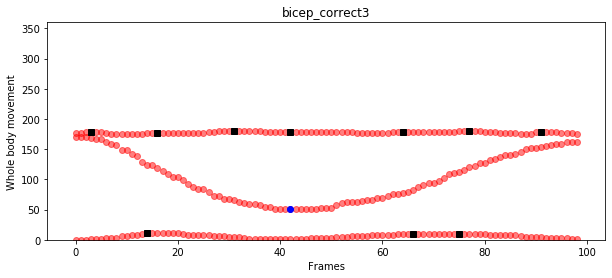

Angles between upper arm and trunk
Max angle: 11.970577781550958
Min angle: 0.10820696782098245


Angles between upper arm and forearm
Max angle: 170.75594018741262
Min angle: 48.95150669691576


Starting...
Keypoints from folder: output_points_bicep_side
Detected arm: right
Largest angles between upper arm and trunk: [2.4918844  4.16151413 3.40803396 3.53887889 1.67711543 4.43845479
 3.46229164 3.37897175 7.76228609 1.77538708 8.70500386 6.42669299
 6.83719978 5.45566207]
Largest angles between trunk and knee: [179.93487543 179.40880243 179.34295844 179.98022209 179.46033766
 179.28237917 179.35382389 179.96725921 177.87866705 177.84644874
 178.81500063]
Number of maxima points between Upper Arm and Forearm: 2
[161.9326201  171.88592817]
Number of reps performed: 3
[36.28063958 32.93822519 33.34361794]


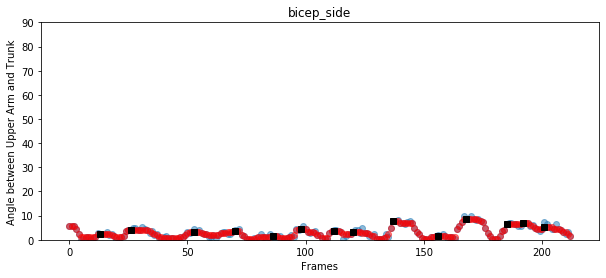

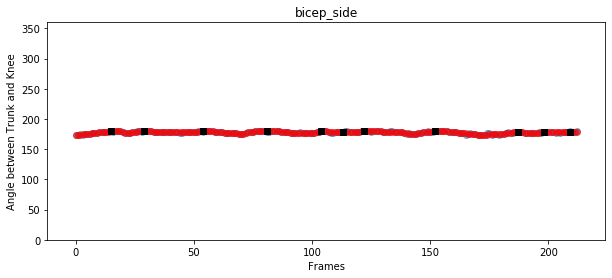

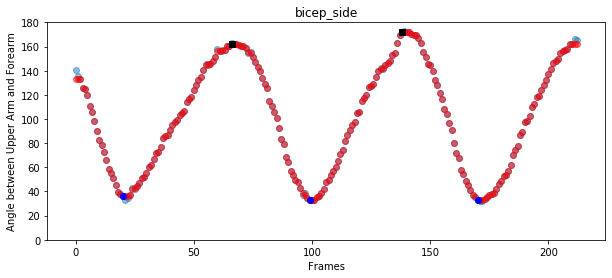

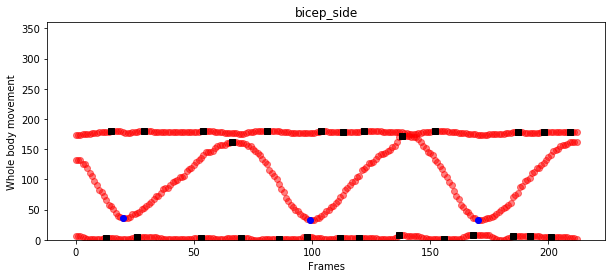

Angles between upper arm and trunk
Max angle: 9.997987857873243
Min angle: 0.0017980164883706796


Angles between upper arm and forearm
Max angle: 172.79989535066863
Min angle: 31.71870423751246


Starting...
Keypoints from folder: output_points_bicep_side5
Detected arm: right
Largest angles between upper arm and trunk: [ 2.50368121  4.82096684  3.38236655  4.23478354  1.17418743  4.54773386
  3.54005481  3.41315599  7.4206274   7.70608808  1.79028067  8.69096512
  6.66627133  5.54632489 11.83331325 11.6122942  10.10711395  5.3908624
  5.805808   13.41519351 11.62567878]
Largest angles between trunk and knee: [179.96206353 179.32887556 179.33737149 179.97695088 179.22893253
 178.64381485 179.33292376 179.29083658 179.97549197 174.93811783
 177.9411446  179.69058397 178.34389411 176.33170501 178.59995637
 179.39891844 178.49854451 175.7045462  175.92807552 178.73407195]
Number of maxima points between Upper Arm and Forearm: 4
[162.3797081  172.11784873 165.09188447 167.41264557]
Number 

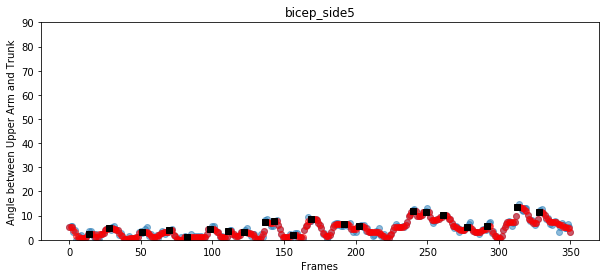

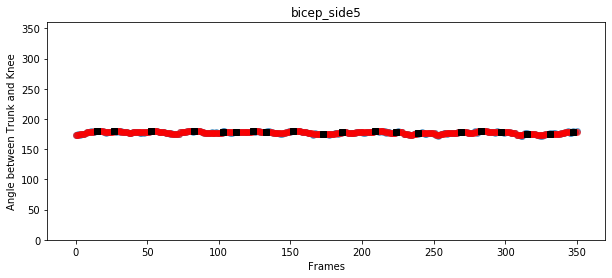

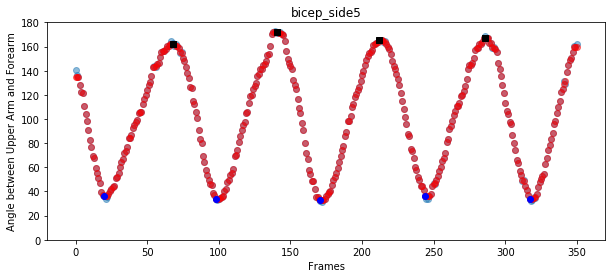

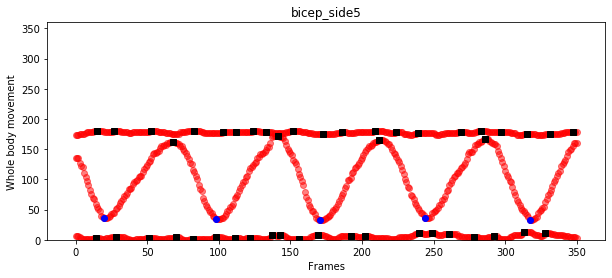

Angles between upper arm and trunk
Max angle: 14.719420138527669
Min angle: 0.00515994411044914


Angles between upper arm and forearm
Max angle: 172.72608189074154
Min angle: 31.68866926211813




In [14]:
# modify this path for other videos 
# input_folder = "/home/aleko/Documents/Projects/IndividualProject/bicepvid"
input_folder = "C:\\Users\\altaok\\Documents\\GitHub\\IndividualProject\\keypoints_for_all"
folder_paths = glob.glob(os.path.join(input_folder, 'output_points_bicep*'))

# Return unit vector
def unit_vector(vect):
    return vect / np.linalg.norm(vect)

# Calcute angle between vectors
def calc_angle(vect1, vect2):
    unit_vect1 = unit_vector(vect1)
    unit_vect2 = unit_vector(vect2)
    return math.degrees(np.arccos(np.clip(np.dot(unit_vect1, unit_vect2), -1.0, 1.0)))

# Detecting sides (left or right) on videos  
# can use this method for other exercises
def detect_side(frame_poses):
    side = ''
    rside_joints = [pose.joint_keypoints['RSHOULDER'] + pose.joint_keypoints['RELBOW'] + pose.joint_keypoints['RWRIST'] + pose.joint_keypoints['RHIP'] + pose.joint_keypoints['RKNEE'] for pose in frame_poses 
                    if pose.joint_keypoints['RSHOULDER'][2]!=0 and pose.joint_keypoints['RELBOW'][2]!=0 and pose.joint_keypoints['RWRIST'][2]!=0 and pose.joint_keypoints['RHIP'][2]!=0 and pose.joint_keypoints['RKNEE'][2]!=0]
    
    lside_joints = [pose.joint_keypoints['LSHOULDER'] + pose.joint_keypoints['LELBOW'] +  pose.joint_keypoints['LWRIST'] + pose.joint_keypoints['LHIP'] + pose.joint_keypoints['LKNEE'] for pose in frame_poses 
                    if pose.joint_keypoints['LSHOULDER'][2]!=0 and pose.joint_keypoints['LELBOW'][2]!=0 and pose.joint_keypoints['LWRIST'][2]!=0 and pose.joint_keypoints['LHIP'][2]!=0 and pose.joint_keypoints['LKNEE'][2]!=0]
    
    # think about the case when they are equal
    if len(rside_joints) > len(lside_joints): 
        side = 'right'
    else: 
        side = 'left'
    
    return side
    

# Finds extrema points in numpy arrray
def find_extremas(filtered_nparray, maxima=True):
        if maxima:
            points = _boolrelextrema(filtered_nparray, np.greater, order=1)
        else:
            points = _boolrelextrema(filtered_nparray, np.less, order=1)
       
        indexes = np.nonzero(points)[0]
        extrema_points = np.take(filtered_nparray, indexes)
        return extrema_points, indexes    
    
# Method used for finding local minima points for repetition counting
# https://github.com/scipy/scipy/blob/master/scipy/signal/_peak_finding.py
def _boolrelextrema(data, comparator, axis=0, order=1, mode='clip'):
    if((int(order) != order) or (order < 1)):
        raise ValueError('Order must be an int >= 1')

    datalen = data.shape[axis]
    locs = np.arange(0, datalen)
    data = np.ma.masked_array(data, mask=np.hstack(([1], np.diff(data)))==0)
    if np.ma.is_masked(data):
        locs = locs[np.ma.getmask(data)==False]
        main = data.take(locs, axis=axis, mode=mode)
        results = np.zeros(data.shape, dtype=bool)
        for index, result in enumerate(_boolrelextrema(main, comparator, axis=axis, order=order, mode=mode)):
            results[locs[index]] = result
        return results
    else:
        locs = locs[np.ma.getmask(data)==False]
        results = np.ones(data.shape, dtype=bool)
        main = data.take(locs, axis=axis, mode=mode)
        for shift in range(1, order + 1):
            plus = data.take(locs + shift, axis=axis, mode=mode)
            minus = data.take(locs - shift, axis=axis, mode=mode)
            results &= comparator(main, plus)
            results &= comparator(main, minus)
            if(~results.any()):
                return results
        return results



for folder in folder_paths:
    video_name = os.path.basename(folder).replace('output_points_', '')
    frame_poses = parse_frames(folder)
                        
    # Computing angles
    trunk_vects = []
    upArm_forearm_angles = [] 
    upArm_trunk_angles = []
    trunk_knee_angles = []
    upArm_vects = []
    knee_vects = []
    forearm_vects = []
    
    # Detect side
    side = detect_side(frame_poses)
    print('Detected arm: ' + side)

    for posture in frame_poses:
        if side == 'right':
            parts = [posture.joint_keypoints['RSHOULDER'], posture.joint_keypoints['RELBOW'], posture.joint_keypoints['RWRIST'], posture.joint_keypoints['RHIP'], posture.joint_keypoints['RKNEE']]
        else: 
            parts = [posture.joint_keypoints['LSHOULDER'], posture.joint_keypoints['LELBOW'], posture.joint_keypoints['LWRIST'], posture.joint_keypoints['LHIP'], posture.joint_keypoints['LKNEE']]

        # upper arm 
        # [0]- x; [1] - y, [2] - c
        upArm_vect = [parts[0][0] - parts[1][0], parts[0][1] - parts[1][1]]
        upArm_vects.append(upArm_vect)
                 
        # trunk
        trunk_vect = [posture.joint_keypoints['NECK'][0] - posture.joint_keypoints['MIDHIP'][0], posture.joint_keypoints['NECK'][1] - posture.joint_keypoints['MIDHIP'][1]]
        trunk_vects.append(trunk_vect)
        # Calculate upper arm and trunk angle
        # convert to unit vectors
        upArm_vect = unit_vector(upArm_vect)
        trunk_vect = unit_vector(trunk_vect)

        # Calculate angle and add to list
        upArm_trunk_angles.append(calc_angle(upArm_vect, trunk_vect))

        # forearm
        forearm_vect = [parts[2][0] - parts[1][0], parts[2][1] - parts[1][1]]
        forearm_vects.append(forearm_vect)
        # Calculate upper arm and forearm angle 
        forearm_vect = unit_vector(forearm_vect)
        upArm_forearm_angles.append(calc_angle(upArm_vect, forearm_vect))
        
        # knee 
        knee_vect = [parts[4][0] - parts[3][0], parts[4][1] - parts[3][1]]
        knee_vects.append(knee_vect)
        # Calculate trunk and knee angle 
        trunk_knee_angles.append(calc_angle(trunk_vect, knee_vect))
        


    # for now use medfilt
    # might use Kalman filter or something later instead
    upArm_vects = np.array(upArm_vects)
    trunk_vects = np.array(trunk_vects)
    knee_vects = np.array(knee_vects)
    upArm_trunk_angles = np.array(upArm_trunk_angles)
    upArm_trunk_angles_filtered = medfilt(upArm_trunk_angles, 5)
    upArm_trunk_angles_filtered = medfilt(upArm_trunk_angles_filtered, 5)
    upArm_forearm_angles = np.array(upArm_forearm_angles)
    upArm_forearm_angles_filtered = medfilt(upArm_forearm_angles, 5)
    upArm_forearm_angles_filtered = medfilt(upArm_forearm_angles, 5)
    trunk_knee_angles = np.array(trunk_knee_angles)
    trunk_knee_angles_filtered = medfilt(trunk_knee_angles, 5)
    trunk_knee_angles_filtered = medfilt(trunk_knee_angles_filtered, 5)
    
              
    
    # Find upper arm and trunk maximum angles to detect wrong form 
    upArm_trunk_maximas, indexesmax1 = find_extremas(upArm_trunk_angles_filtered)
    print("Largest angles between upper arm and trunk: " + str(upArm_trunk_maximas))
   
    # Find trunk and knee maximum angles to detect wrong form 
    trunk_knee_maximas, indexesmax2 = find_extremas(trunk_knee_angles_filtered)
    print("Largest angles between trunk and knee: " + str(trunk_knee_maximas))
       
    # Count repetitions
    upArm_forearm_maximas, indexesmax3 = find_extremas(upArm_forearm_angles_filtered)    
    print("Number of maxima points between Upper Arm and Forearm: " + str(upArm_forearm_maximas.size))
    print(upArm_forearm_maximas)
    
    # Find upper arm and forearm minimum points to count reps 
    upArm_forearm_minimas, indexesmin = find_extremas(upArm_forearm_angles_filtered, maxima=False)
    print("Number of reps performed: " + str(upArm_forearm_minimas.size))
    print(upArm_forearm_minimas)

   
    # Plot 1
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_trunk_angles.shape[0]), upArm_trunk_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Trunk')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,90)
    
    # Annontate maxima points
    plt.plot(indexesmax1, upArm_trunk_angles_filtered[indexesmax1], 'ks')
    plt.show()
    
    # Plot 2
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(trunk_knee_angles.shape[0]), trunk_knee_angles, alpha=0.5)
    plt.scatter(np.arange(trunk_knee_angles_filtered.shape[0]), trunk_knee_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Trunk and Knee')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,360)
    
    # Annontate maxima points
    plt.plot(indexesmax2, trunk_knee_angles_filtered[indexesmax2], 'ks')
    plt.show()

    # Plot 3
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_forearm_angles.shape[0]), upArm_forearm_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Forearm')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,180) 
    
    # Annotate minima apoints on the graph       
    plt.plot(indexesmin, upArm_forearm_angles_filtered[indexesmin], 'bo')
    plt.plot(indexesmax3, upArm_forearm_angles_filtered[indexesmax3], 'ks')
    plt.show()
    
    # Plot 4
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.scatter(np.arange(trunk_knee_angles_filtered.shape[0]), trunk_knee_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Whole body movement')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,360) 
    # Annotate minima apoints      
    plt.plot(indexesmin, upArm_forearm_angles_filtered[indexesmin], 'bo')
    plt.plot(indexesmax1, upArm_trunk_angles_filtered[indexesmax1], 'ks')
    plt.plot(indexesmax2, trunk_knee_angles_filtered[indexesmax2], 'ks')
    plt.plot(indexesmax3, upArm_forearm_angles_filtered[indexesmax3], 'ks')
    
    plt.show()
    
    print("Angles between upper arm and trunk\nMax angle: " + str(np.max(upArm_trunk_angles)) + "\nMin angle: " + str(np.min(upArm_trunk_angles)))
    print('\n')
    print("Angles between upper arm and forearm\nMax angle: " + str(np.max(upArm_forearm_angles)) + "\nMin angle: " + str(np.min(upArm_forearm_angles)))
    print('\n' + '='*120 + '\n')